<img src="https://d33wubrfki0l68.cloudfront.net/22691a3c3002324451ed99f4009de8aab761e1b7/d24da/public/images-original/stac-01.png"
     style="margin-right: 10px; width: 25%"/><img src="https://raw.githubusercontent.com/pydata/xarray/main/doc/_static/logos/Xarray_Logo_RGB_Final.png"
     style="margin-right: 10px; width: 25%"/>

# STAC

STAC (SpatioTemporal Asset Catalog) is an open standard designed to facilitate the discovery, search, and use of geospatial data. It defines a common metadata model and web API, allowing users to catalog, search, and access various types of geospatial data, such as satellite imagery, aerial photos, and other spatial datasets. STAC aims to improve interoperability between different data providers and users, making it easier to work with large volumes of geospatial information in a standardized way.

A STAC Catalog is the root document that provides links to Collections, Items, and other Catalogs, serving as an entry point to navigate the structure of geospatial data. A STAC Collection is a group of related Items that share common metadata, offering information about the dataset's spatial and temporal extent and linking to individual Items. A STAC Item represents a single geospatial asset, such as a satellite image or drone photograph, and includes metadata like acquisition time, location, and links to data files (Assets). An Asset is a data file associated with a STAC Item, including various types of data like images or metadata documents, each with a URL and metadata describing its type, format, and role.

To get to know the structure you can take a quick look at the EODC Data Catalogue:

https://services.eodc.eu/browser/#/?.language=en


Further you can look at the AI4SAR_SIG0 catalogue:

https://services.eodc.eu/browser/#/v1/collections/AI4SAR_SIG0


The database we will work with in this notebook is provided by the EODC. The European Open Data Center (EODC) is an organization that provides access to extensive Earth observation data and services, facilitating the management, processing, and analysis of geospatial information. EODC offers a variety of datasets, including satellite imagery from missions such as Sentinel and Landsat, which are essential for environmental monitoring, climate research, and other geospatial applications. 




# Exploring Data with STAC and Xarray

In this notebook, we will demonstrate how to use the STAC API in conjunction with open-source Python libraries to load data into *Xarray* via *odc-stac*. The objective of this notebook is to showcase the integration of data discovery (using STAC) and data analysis (using Xarray).

Xarray is an open-source Python library designed to handle multi-dimensional arrays and datasets, extending the capabilities of NumPy. It provides labeled arrays and datasets, enabling users to work with complex data structures like time series, climate data, and other scientific datasets. Xarray integrates seamlessly with other scientific libraries like Pandas and Dask, allowing for efficient data manipulation, analysis, and visualization.

## Import required packages

In [2]:
#These are the important packages we first need to import 

import os
import json
from datetime import datetime
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt

import pystac
from pystac_client import Client
from odc import stac as odc_stac
from odc.geo.geobox import GeoBox
from affine import Affine
import sys

In [3]:
#The code here adjusts the width of the nootebook display container

from IPython.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

## Create STAC client and connecting to the server

The API (Application Programmin Interface) we use connects us with the EODC database using STAC convention. If we open https://stac.eodc.eu/api/v1 in our browser we will see a JSON file including a set of links below "conformsTo" which describes the structure of the API for example how we filter through catalogues looking for items. Below "links" we will find the links to the catalogues themselves. This JSON file is basically the underlying structure for the catalogue we already opened before showing us the EODC web interface of the catalogue (https://services.eodc.eu/browser/#/?.language=en).


The AI4SAR collection we will work with includes a few items from Sentinel 1 for differnt times in the year 2023 nearby the area of Austria.

In [4]:
#This is how we access the AI4SAR collection via the stac_api

stac_api = "https://stac.eodc.eu/api/v1"
client = Client.open(stac_api)

collection_id="AI4SAR_SIG0"

## Load STAC Items into xarray Dataset using odc.stac

In [5]:
#This gives us an overview of the metadata of the collection we want to work with

collection = client.get_collection("AI4SAR_SIG0")
collection

<CollectionClient id=AI4SAR_SIG0>

For now we still have not accessed the real data that is stored at EODC. We just have loaded the meta data into our local memory. If we look at the size of it it is negligibly small .

In [30]:

collection_size = sys.getsizeof(collection)
print('Collection size: %.1f KB' % (collection_size / 1024))

Collection size: 0.0 KB


In [6]:
#Next we search for certain items in the AI4SAR_SIG0 collection, defining the area and time period
collection_id="AI4SAR_SIG0"

bbox = [15.6, 47.7, 16.6, 48.7]  # [lon_min, lat_min, lon_max, lat_max]
start_date = "2023-01-01"
end_date = "2023-10-31"

query = client.search(bbox=bbox,
                        collections=[collection_id],
                        datetime=f"{start_date}/{end_date}",
                        )
q_items = sorted(query.items(), key=lambda x: x.id)

In [7]:
for item in q_items:
    print(item)

print("\n","The length of the list of items is",len(q_items))



<Item id=SIG0_20230418T050210_D124_EU020M_E051N015T3_S1AIWGRDH>
<Item id=SIG0_20230512T050211_D124_EU020M_E051N015T3_S1AIWGRDH>
<Item id=SIG0_20230617T050213_D124_EU020M_E051N015T3_S1AIWGRDH>

 The length of the list of items is 3


Just to make it clear the items we retrieved from our collection are still metadata. The real data provided by EODC is still not accessed. 

In [8]:
#Here we take a look at the metadata of one item.

q_items[0].properties

{'gsd': 20,
 'datetime': '2023-04-18T05:02:10Z',
 'proj:bbox': [5100000, 1500000, 5400000, 1800000],
 'proj:wkt2': 'PROJCS["Azimuthal_Equidistant",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433],AUTHORITY["EPSG","4326"]],PROJECTION["Azimuthal_Equidistant"],PARAMETER["latitude_of_center",53],PARAMETER["longitude_of_center",24],PARAMETER["false_easting",5837287.81977],PARAMETER["false_northing",2121415.69617],UNIT["metre",1,AUTHORITY["EPSG","9001"]]]',
 'proj:shape': [15000, 15000],
 'constellation': 'sentinel-1',
 'proj:geometry': {'type': 'Polygon',
  'coordinates': [[[5100000.0, 1500000.0],
    [5100000.0, 1800000.0],
    [5400000.0, 1800000.0],
    [5400000.0, 1500000.0],
    [5100000.0, 1500000.0]]]},
 'proj:transform': [20, 0, 5100000, 0, -20, 1800000],
 'sat:orbit_state': 'descending',
 'sar:product_type': 'GRD',
 'sar:frequency_band': 'C',
 'sat:rel

When we take a look at the assets of one item it means to take a closer look at what real data is connected to our metadata. It tells us what data we could eventually work with.

In [31]:
q_items[0].assets

{'VH': <Asset href=https://data.eodc.eu/collections/AI4SAR_SIG0/EQUI7_EU020M/E051N015T3/SIG0_20230418T050210__VH_D124_E051N015T3_EU020M_V1M1R2_S1AIWGRDH_TUWIEN.tif>,
 'VV': <Asset href=https://data.eodc.eu/collections/AI4SAR_SIG0/EQUI7_EU020M/E051N015T3/SIG0_20230418T050210__VV_D124_E051N015T3_EU020M_V1M1R2_S1AIWGRDH_TUWIEN.tif>,
 'thumbnail': <Asset href=https://data.eodc.eu/collections/AI4SAR_SIG0/EQUI7_EU020M/E051N015T3/SIG0_20230418T050210__VV_D124_E051N015T3_EU020M_V1M1R2_S1AIWGRDH_TUWIEN.tif/thumbnail>}

Now we gathered all the information we need to finally download the real data from the EODC server into our local memory. To to this we use the odc package which helps us to convert the data from the EODC server into an Xarray on our local memory.


In [10]:
bands = ("VV", "VH")
crs = "EPSG:4326"
bbox = [15.6, 47.7, 16.6, 48.7]
res = 0.00018 # 20 meter in degree
sig0_ds = odc_stac.stac_load(q_items,
                        bands=bands,
                        crs=crs,
                        resolution=res,
                        bbox=bbox,
                        use_overviews=False,
                        )

In [26]:
print('The sig0_ds xarray has %.1f MB' % (sig0_ds.nbytes / 1e6))

The sig0_ds xarray has 370.6 MB


The Xarray that we downloaded into our local memory includes the dimensions latitude, longitude and time. The data variables for these dimensions are our VV and VH polarisation values. This means that we for example could pick one georeferenced point, look at one of the 3 moments in time we got and then decide if we want to look at the value for VV or VH polarisation for this exact moment and this exact georefernced point.

In [11]:
sig0_ds

<xarray.Dataset> Size: 371MB
Dimensions:      (latitude: 5556, longitude: 5557, time: 3)
Coordinates:
  * latitude     (latitude) float64 44kB 48.7 48.7 48.7 48.7 ... 47.7 47.7 47.7
  * longitude    (longitude) float64 44kB 15.6 15.6 15.6 15.6 ... 16.6 16.6 16.6
    spatial_ref  int32 4B 4326
  * time         (time) datetime64[ns] 24B 2023-04-18T05:02:10 ... 2023-06-17...
Data variables:
    VV           (time, latitude, longitude) int16 185MB -9999 -9999 ... -97 -97
    VH           (time, latitude, longitude) int16 185MB -9999 -9999 ... -165

This means that we for example could pick one georeferenced point, look at one of the 3 moments in time we got and then decide if we want to look at the value for VV or VH polarisation for this exact moment and this exact georefernced point.

In [12]:
#This is how what we just described would transalte to code
#We look at the georeferenced point (100,200) for moment 0 and look at the VV polarisation value  

sig0_ds.VV[0,100,200]

<xarray.DataArray 'VV' ()> Size: 2B
array(-129, dtype=int16)
Coordinates:
    latitude     float64 8B 48.68
    longitude    float64 8B 15.64
    spatial_ref  int32 4B 4326
    time         datetime64[ns] 8B 2023-04-18T05:02:10
Attributes:
    nodata:   -9999

In [13]:
#Here we take a look at the VV polarisation values for all the points we have for moment 0
sig0_ds.VV[0,:,:]

<xarray.DataArray 'VV' (latitude: 5556, longitude: 5557)> Size: 62MB
array([[-9999, -9999, -9999, ...,  -103,  -100,  -100],
       [-9999, -9999, -9999, ...,  -104,  -101,  -101],
       [-9999, -9999, -9999, ...,  -102,  -100,  -100],
       ...,
       [ -169,  -169,  -169, ...,   -87,   -97,  -103],
       [ -163,  -163,  -163, ...,   -95,   -96,   -98],
       [ -144,  -147,  -151, ...,  -100,   -96,   -96]], dtype=int16)
Coordinates:
  * latitude     (latitude) float64 44kB 48.7 48.7 48.7 48.7 ... 47.7 47.7 47.7
  * longitude    (longitude) float64 44kB 15.6 15.6 15.6 15.6 ... 16.6 16.6 16.6
    spatial_ref  int32 4B 4326
    time         datetime64[ns] 8B 2023-04-18T05:02:10
Attributes:
    nodata:   -9999

## Visualizing the data

We see that the values have a wide range from values of -9999 to values that are somewhere around 100. If we visualize the values just like this there would not be much to be seen.

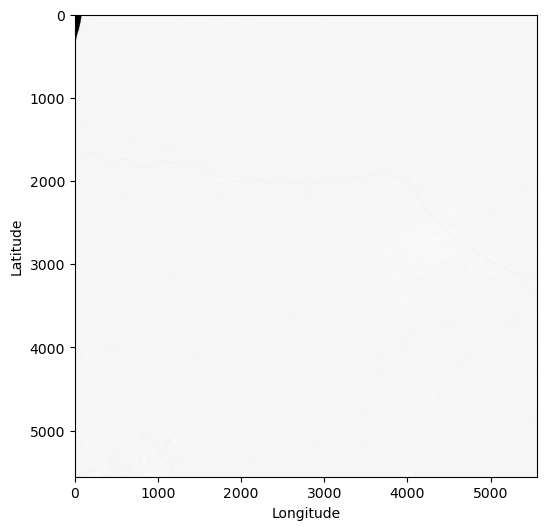

In [14]:
vv_data = sig0_ds.VV[0,:,:]

# Plot the data
plt.figure(figsize=(10, 6))
plt.imshow(vv_data, cmap='gray')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()


The information we are working with has undergone extensive processing to finally be stored in our local memory, including the influence of sensor data, various corrections, transformations, and steps to store and transmit the data. Given this complexity, we cannot be entirely sure of the cleanliness and scaling of the values. Therefore, to visualize the data properly, we need to perform two crucial steps: first, we need to delete the invalid or placeholder values that do not provide valuable information, such as the -9999 values in our example and second, we must scale the values between 1 and 255 because this range corresponds to the variety an 8-bit pixel on our screen can display.

In [15]:
#To transform our data following the two steps from above we create the function:

def scale_image(arr, nodata, vmin=None, vmax=None):
    
    v_idx = arr!=nodata
    
    v = arr[v_idx]

    if vmin is None:
        
        vmin = np.min(v)
    if vmax is None:
        vmax = np.max(v)
    
    out = np.copy(arr)
    # scale between 1 and 255 and leave 0 for nodata
    out = (out-vmin) * (254/(vmax-vmin)) + 1
    out[~v_idx] = 0

    return out.astype(np.uint8)
print('Test6')


Test6


In [16]:
#Here we take a look at the smallest and biggest value in the array

for i in range(3):

    print('min:',sig0_ds.VV[i,:,:].min().values,'max:',sig0_ds.VV[i,:,:].max().values)

min: -9999 max: 266
min: -9999 max: 288
min: -9999 max: 286


Sentinel-1 data includes two types of polarization modes: Vertical-Vertical (VV) and Vertical-Horizontal (VH). VV polarization means that the radar signal is transmitted and received with vertical polarization, which is useful for capturing detailed surface structures—such as the arrangement and shape of objects like buildings and vegetation—and is less sensitive to volume scattering. VH polarization, on the other hand, transmits a vertically polarized signal and receives a horizontally polarized signal. This mode is effective in detecting differences in surface roughness, which refers to the small-scale irregularities or texture of a surface, and vegetation structures due to its sensitivity to changes in surface features. 

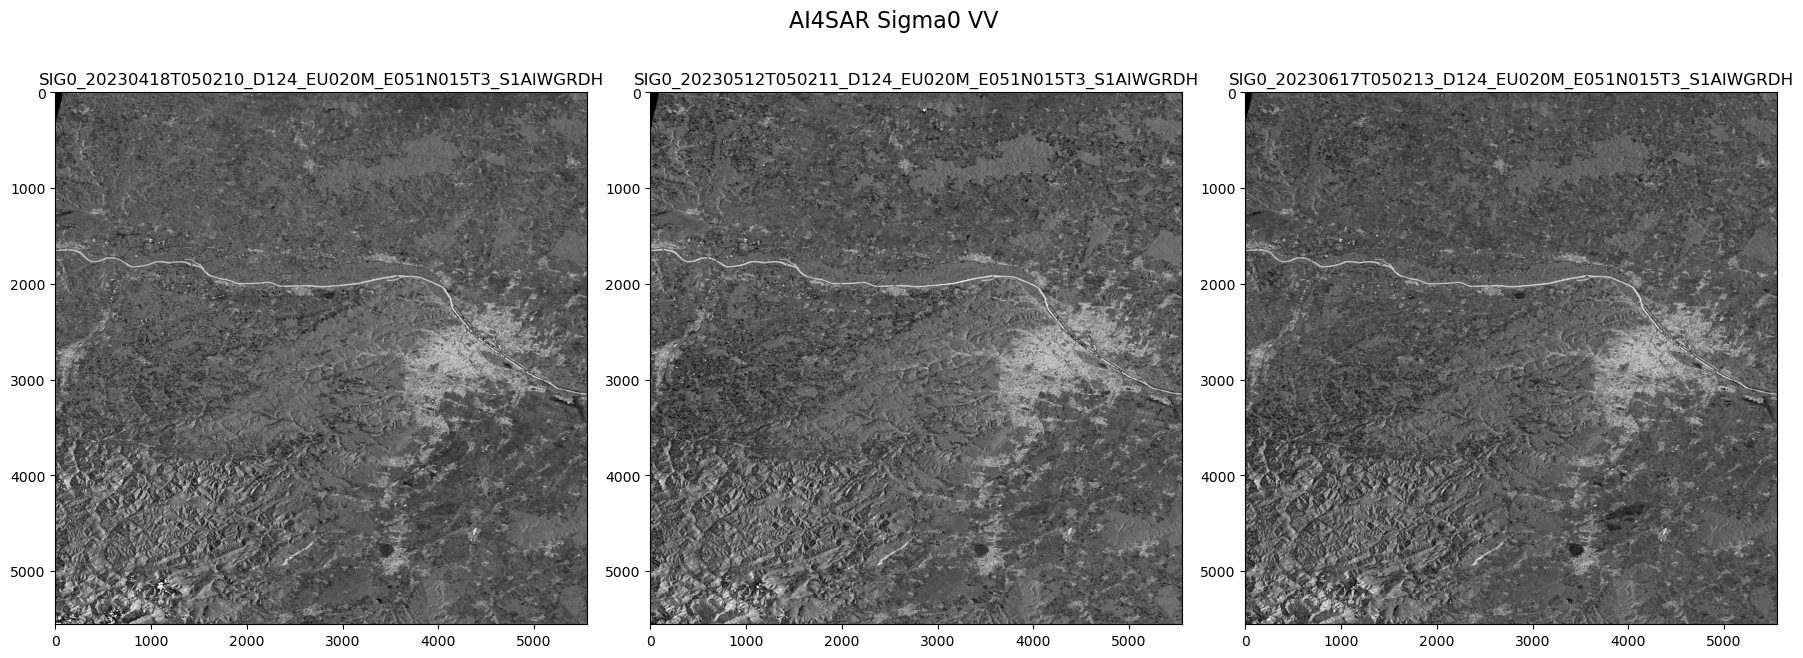

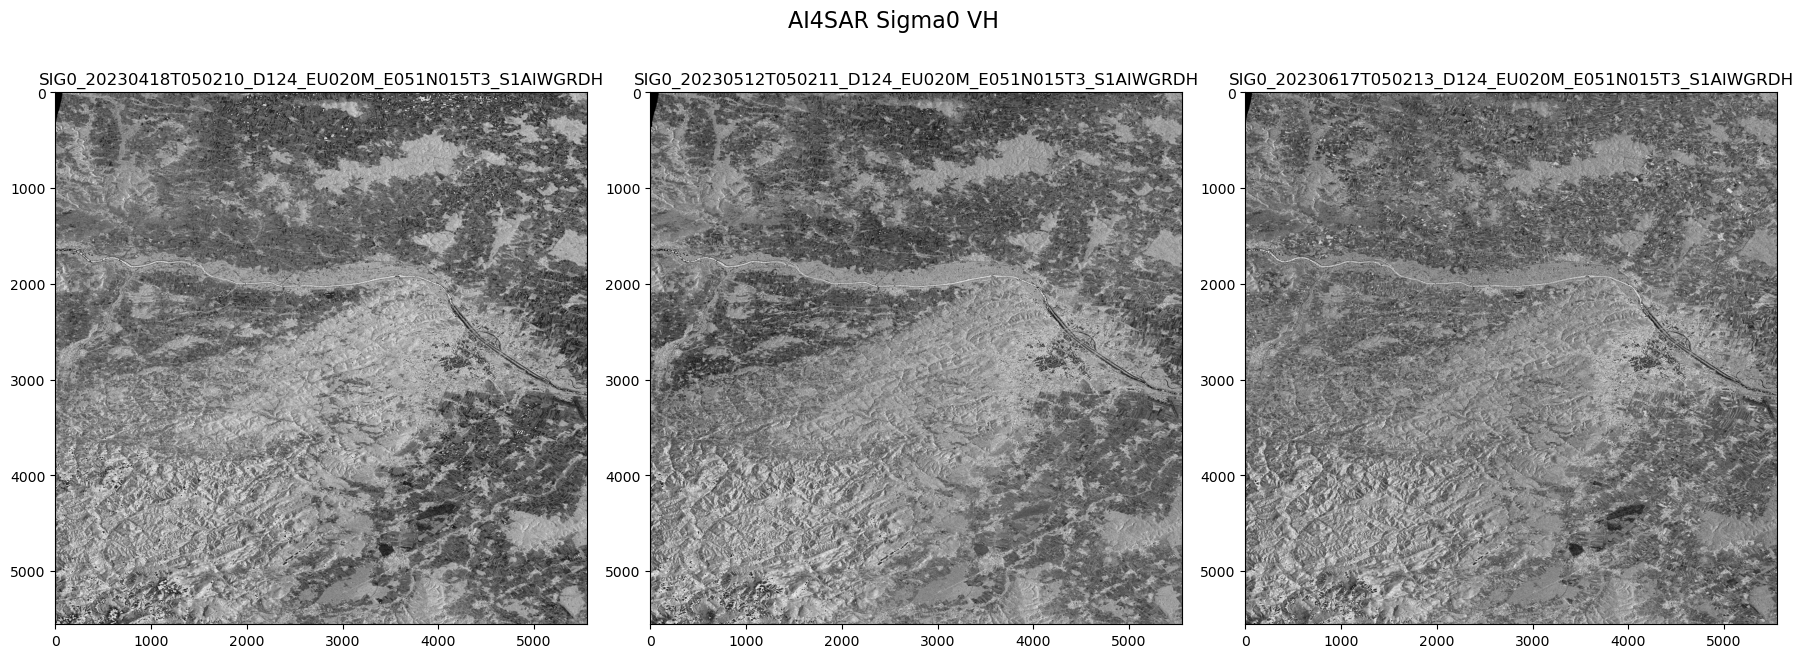

In [17]:
#Here we visualize the VV polarization values for the three moments in time we have

fig1 = plt.figure(figsize=(18, 6))
fig1.suptitle('AI4SAR Sigma0 VV', fontsize=16, y=1.05)
nodata = -9999

for i in range(3):
    
    img = sig0_ds.VV[i,:,:].to_numpy()
    name = q_items[i].id

    gray_img = scale_image(img, nodata, vmin=-170, vmax=20)

    ax = fig1.add_subplot(1, 3, i+1)
    ax.set_title(name)
    ax.imshow(gray_img, cmap='gray')


plt.tight_layout()

#Here we visualize the VH polarization values for the three moments in time we have

fig1 = plt.figure(figsize=(18, 6))
fig1.suptitle('AI4SAR Sigma0 VH', fontsize=16, y=1.05)
nodata = -9999

for i in range(3):
    
    img = sig0_ds.VH[i,:,:].to_numpy()
    name = q_items[i].id

    gray_img = scale_image(img, nodata, vmin=-240, vmax=-100)

    ax = fig1.add_subplot(1, 3, i+1)
    ax.set_title(name)
    ax.imshow(gray_img, cmap='gray')


plt.tight_layout()

### Load data in orginal CRS

My guess would be that you transform it to another maybe more commonly used crs.

Also we could maybe leave this section out because it could be unnecessary and confusing for Data Science students.

In [18]:
bands = ("VV")
org_crs = q_items[0].properties["proj:wkt2"] #EU_E051N015T3
west, south, east, north = 5240000, 1580000, 5320000, 1640000
org_res = 20
shape = (int((north-south) / 20), int((east-west) / 20))
gbox = GeoBox(shape, crs=org_crs, affine=Affine(org_res, 0, west, 0, -org_res, north))


sig0_org_ds = odc_stac.stac_load(q_items,
                        bands=bands,
                        geobox=gbox,
                        use_overviews=False,
                        )

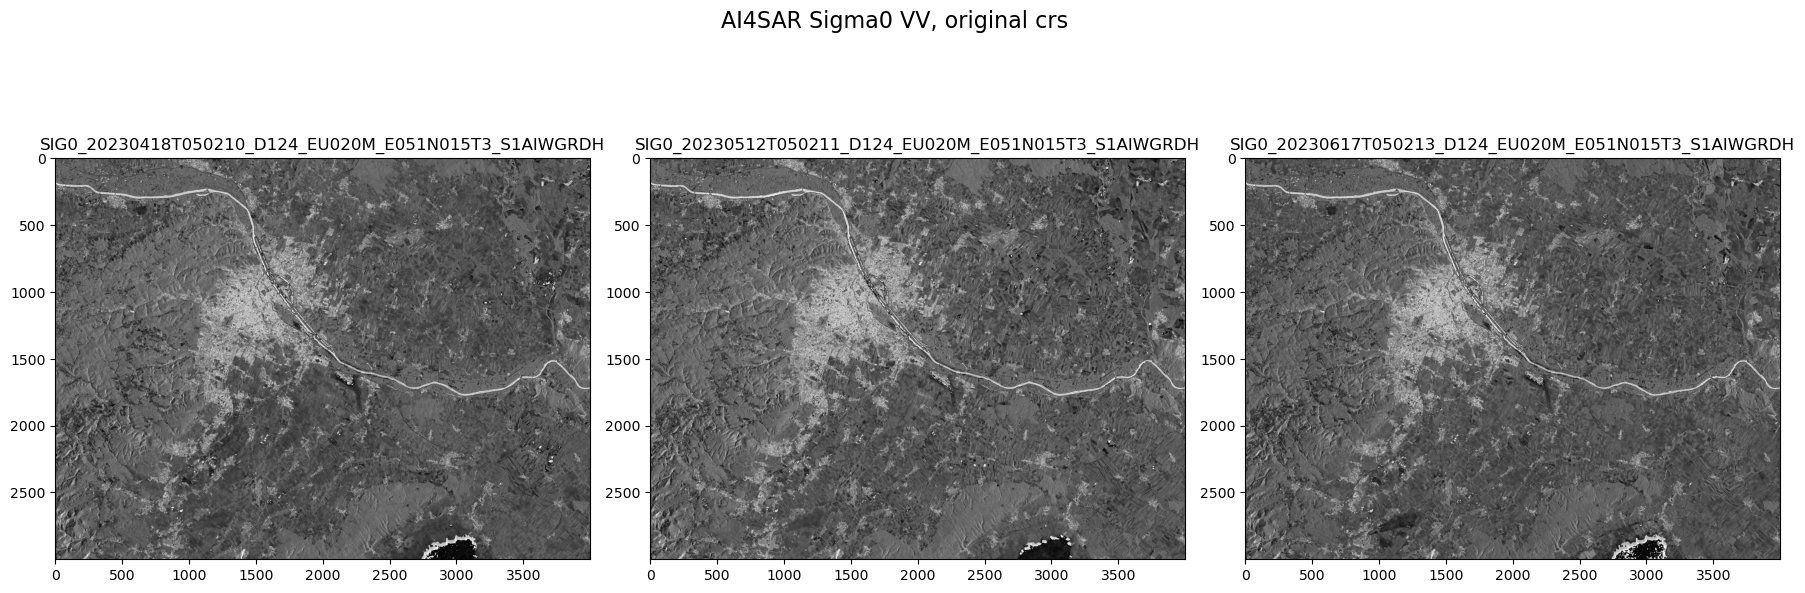

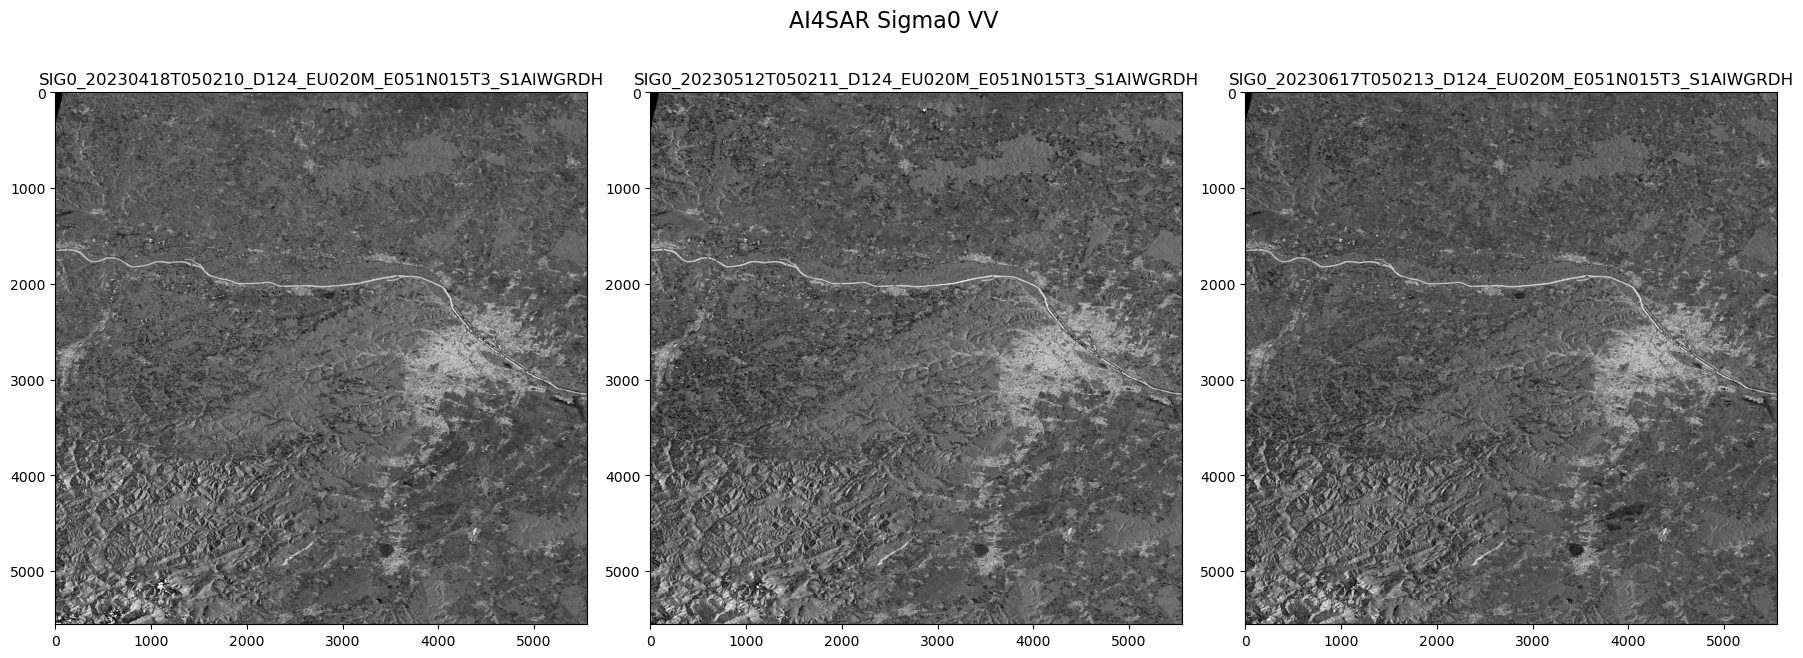

In [19]:
#Here we visualize the VV polarization values in the original crs

fig1 = plt.figure(figsize=(18, 6))
fig1.suptitle('AI4SAR Sigma0 VV, original crs', fontsize=16, y=1.05)
nodata = -9999

for i in range(3):
    
    img = sig0_org_ds.VV[i,:,:].to_numpy()
    name = q_items[i].id

    gray_img = scale_image(img, nodata, vmin=-170, vmax=20)

    ax = fig1.add_subplot(1, 3, i+1)
    ax.set_title(name)
    ax.imshow(gray_img, cmap='gray')


plt.tight_layout()

#Here we visualize the VV polarization values just the way we did before for comparison

fig1 = plt.figure(figsize=(18, 6))
fig1.suptitle('AI4SAR Sigma0 VV', fontsize=16, y=1.05)
nodata = -9999

for i in range(3):
    
    img = sig0_ds.VV[i,:,:].to_numpy()
    name = q_items[i].id

    gray_img = scale_image(img, nodata, vmin=-170, vmax=20)

    ax = fig1.add_subplot(1, 3, i+1)
    ax.set_title(name)
    ax.imshow(gray_img, cmap='gray')


plt.tight_layout()

## Simple analysis

So what we do here is calculating the mean values of the three moments in time we have in our Xarray for each geo referenced point. Doing this could have a few practical aspects like analyzing long-term trends, noise reduction, land cover classification, soil moisture, vegetation health and biomass etc.

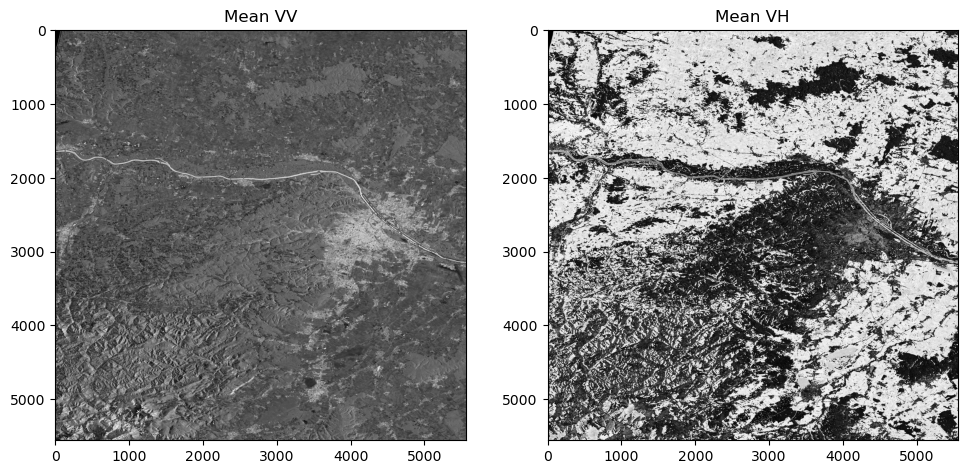

In [20]:
fig1 = plt.figure(figsize=(18, 6))
nodata = -9999

# mean VV
vv_img  = sig0_ds.VV.mean(dim='time').to_numpy()
vv_gray_img = scale_image(vv_img, nodata, vmin=-170, vmax=20)
ax = fig1.add_subplot(1, 3, 1)
ax.set_title("Mean VV")
ax.imshow(vv_gray_img, cmap='gray')

# mean VH
vh_img = sig0_ds.VH.mean(dim='time').to_numpy()
vh_gray_img = scale_image(vh_img, nodata, vmin=-170, vmax=20)
ax = fig1.add_subplot(1, 3, 2)
ax.set_title("Mean VH")
ax.imshow(vh_gray_img, cmap='gray')

In [21]:
try:
    # Try to import the package
    import skimage
    print('scikit-image is already installed.')
except ImportError:
    # If the package is not installed, install it
    !pip install scikit-image
    from IPython.display import clear_output
    clear_output()
    print('Installation of scikit-image completed!')

scikit-image is already installed.


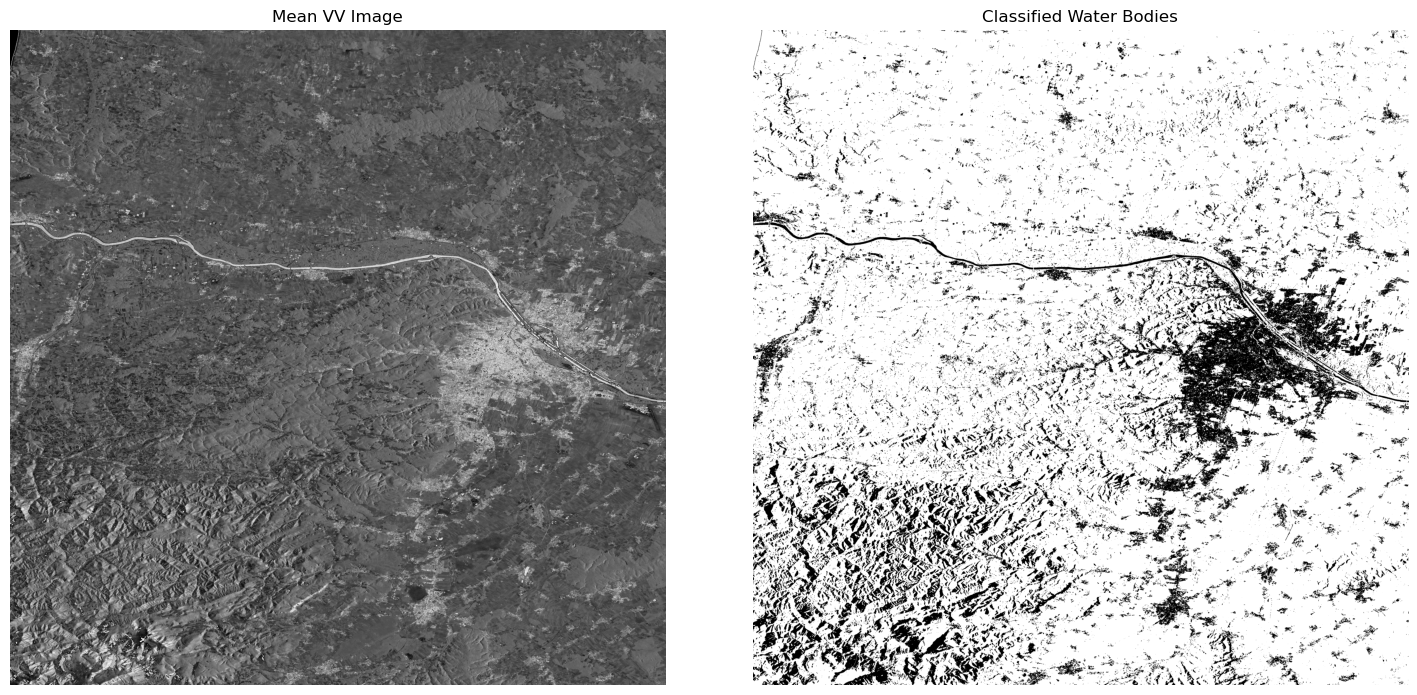

In [22]:
from skimage import filters

# Assuming vv_img is your mean VV data as a 2D numpy array
vv_img = sig0_ds.VV.mean(dim='time').to_numpy()
vv_gray_img = scale_image(vv_img, nodata, vmin=-170, vmax=20)
nodata = -9999



# Apply Otsu's thresholding
threshold_value = filters.threshold_otsu(vv_gray_img)
binary_water = vv_gray_img < threshold_value  # Assuming water bodies have lower VV values

# Plot the original image and the classified binary image
fig, axes = plt.subplots(1, 2, figsize=(15, 7))
ax = axes.ravel()

ax[0].imshow(vv_gray_img, cmap='gray')
ax[0].set_title('Mean VV Image')
ax[0].axis('off')

ax[1].imshow(binary_water, cmap='gray')
ax[1].set_title('Classified Water Bodies')
ax[1].axis('off')

plt.tight_layout()
plt.show()

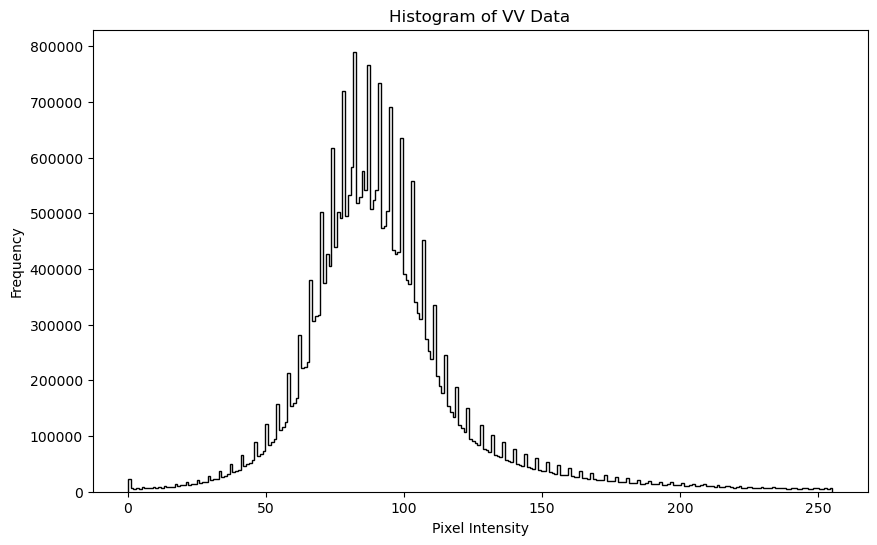

In [23]:
# Assuming vv_img is your mean VV data as a 2D numpy array



vv_img = sig0_ds.VV.mean(dim='time').to_numpy()
vv_gray_img = scale_image(vv_img, nodata, vmin=-170, vmax=20)
nodata = -9999
# Plot the histogram of VV data
plt.figure(figsize=(10, 6))
plt.hist(vv_gray_img.ravel(), bins=256, histtype='step', color='black')
plt.title('Histogram of VV Data')
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')
plt.show()

In [24]:
print(f'Min value: {np.min(vv_gray_img)}, Max value: {np.max(vv_gray_img)}')

Min value: 0, Max value: 255
